In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import line_data
from astropy import constants
import astropy.units as u
import synth
import pymoog
import rulerwd
import os
import re

MOOG_path = '{}/.pymoog/moog_nosm/moog_nosm_NOV2019/'.format(os.environ['HOME'])
MOOG_run_path = '{}/.pymoog/rundir/'.format(os.environ['HOME'])
internal_path = '/media/disk/my_writing/mingjie-workspace/source/he_abun/img/pymoog/'

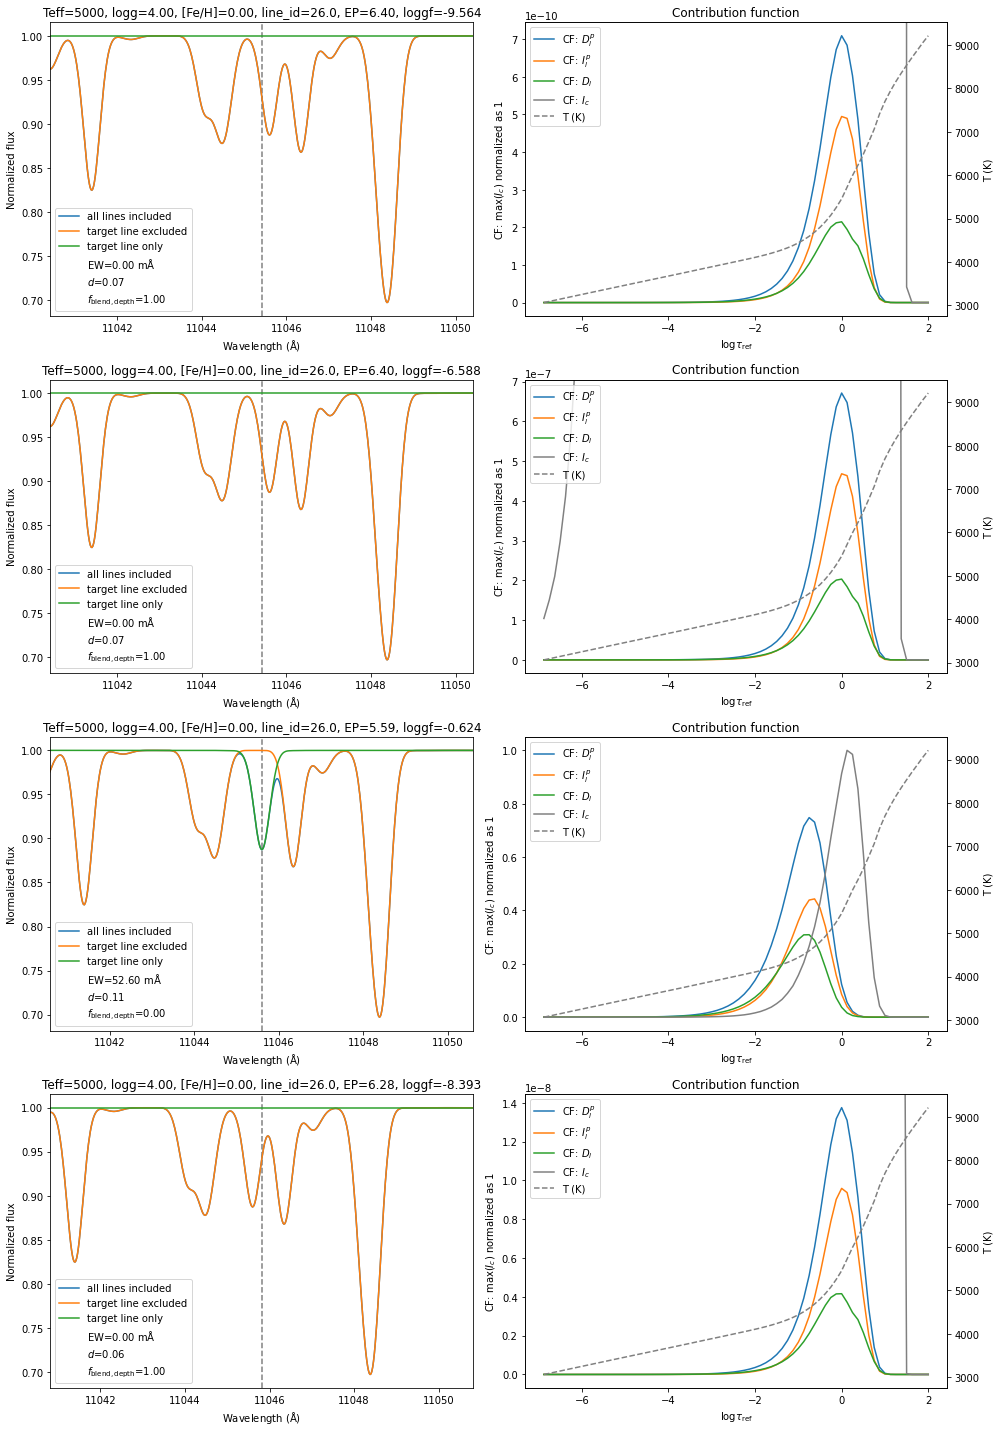

In [62]:
line_wav_input = 11045.599
line_id = 26.0
teff = 5000; logg = 4.0; fe_h = 0 
resolution = 28000
pymoog.contri_func.plot_contri_func(teff, logg, fe_h, resolution, 'vald_11000_24000', line_wav_input=line_wav_input, line_id=line_id)
plt.savefig(internal_path+'contri_func.png', dpi=250)

## Ionization fraction

In [2]:
# Get partition function from MOOG 

def partition_func_single(partition_func_content):
    Z = int(partition_func_content[1][3:5])
    sep_index = []
    ion_state = []
    for i in range(len(partition_func_content)):
        if 'ionization state' in partition_func_content[i]:
            sep_index.append(i)
            ion_state.append(int(partition_func_content[i].split()[-1]))
    sep_index.append(len(partition_func_content))

    partition_func = {}
    for i in range(len(sep_index)-1):
        partition_func[ion_state[i]] = np.array(''.join(partition_func_content[sep_index[i]+1:sep_index[i+1]]).split(), dtype=float) 

    return Z, partition_func

file = open(MOOG_run_path + 'MOOG.out1', 'r')
out1 = file.readlines()

# Extract the "PARTITION FUNCTION" part
for i in range(len(out1)):
    if 'PARTITION FUNCTIONS' in out1[i]:
        start_index = i
    if 'LINE OPACITIES' in out1[i]:
        end_index = i
partition_func_content = out1[start_index:end_index]

sep_index = []
for i in range(len(partition_func_content)):
    if partition_func_content[i] == '\n':
        sep_index.append(i)

partition_func_all = {}

for i in range(len(sep_index)-1):
    Z, partition_single = partition_func_single(partition_func_content[sep_index[i]:sep_index[i+1]])
    partition_func_all[Z] = partition_single


In [9]:
_, atmosphere = pymoog.contri_func.cal_contri_func(MOOG_run_path + 'MOOG.out1')

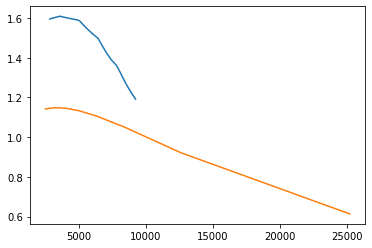

In [17]:
i = 26
plt.plot(atmosphere['T'], partition_func_all[i][1] / partition_func_all[i][0])

theta = np.arange(0.2, 2.1, 0.2)
T = 5040 / theta
p_f0 = np.array([3.76, 2.04, 1.664, 1.519, 1.446, 1.402, 1.372, 1.35, 1.332, 1.317])
p_f1 = np.array([2.307, 1.881, 1.749, 1.682, 1.638, 1.604, 1.575, 1.549, 1.525, 1.504])
plt.plot(T, p_f1/p_f0)

In [ ]:
# Get partition function from OASP

## Abfind

In [5]:
s = pymoog.synth.synth(5000, 4.0, 0, 11045.599-10, 11045.599+10, 28000, line_list='vald_11000_24000')
s.prepare_file()
# s.run_moog()

# linelist = pymoog.line_data.read_linelist(MOOG_run_path + 'line.list')
# indices = (linelist['id'] < 100) & ((linelist['id'] == 19) | (linelist['id'] == 12))
# linelist = linelist[indices].reset_index(drop=True)
# pymoog.line_data.save_linelist(linelist, MOOG_run_path + 'line.list')

In [22]:
wav_range = [11045.599-50, 11045.599+50]
a = pymoog.abfind.abfind(5777, 4.43, 0.0, line_list='line.list')
a.prepare_file()

linelist = pymoog.line_data.read_linelist('vald_11000_24000')
indices = (linelist['id'] < 100) & ((linelist['wavelength'] > wav_range[0]) & (linelist['wavelength'] < wav_range[1])) & (linelist['EW'] > 5)
linelist = linelist[indices].sort_values(['id', 'wavelength']).reset_index(drop=True)
pymoog.line_data.save_linelist(linelist, MOOG_run_path + 'line.list')
a.run_moog(output=True)
a_out = a.read_output() 

 *******************************************************************************
                          MOOG LTE VERSION (NOV 2019)                           
MOOG PARAMETERS; here is the filename: batch.par                                
                       MOOG IS CONTROLLED BY DRIVER abfind 
 *******************************************************************************
STANDARD OUTPUT; here is the filename: MOOG.out1                                
SUMMARY ABUNDANCE OUTPUT; here is the filename: MOOG.out2                       
THE MODEL ATMOSPHERE; here is the filename: model.mod                           
THE LINE LIST; here is the filename: line.list                                  
                                                                                
 <<<<<<<<<<<<<<<<<<<<<<          MOOG HAS ENDED!          >>>>>>>>>>>>>>>>>>>>>>


In [23]:
abfind_df = a.read_output()
ele_index = 26
abfind_s_df = abfind_df[ele_index]

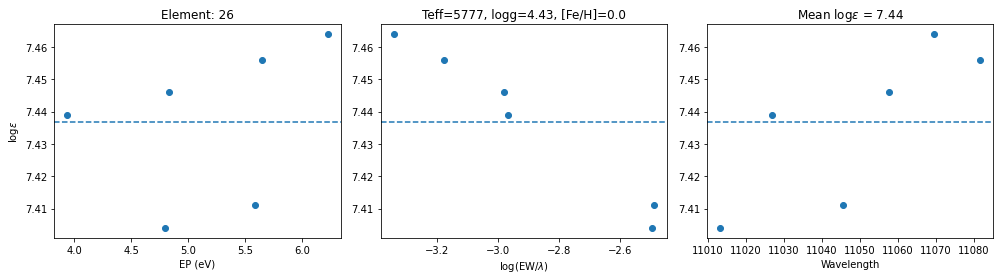

In [39]:
plt.figure(figsize=(14,4))

plt.subplot(131)
plt.scatter(abfind_s_df['EP'], abfind_s_df['abund'])
plt.axhline(np.mean(abfind_s_df['abund']), ls='--')

plt.title('Element: {}'.format(ele_index))
plt.xlabel('EP (eV)'); plt.ylabel('$\log{\epsilon}$')

plt.subplot(132)
plt.scatter(np.log10(abfind_s_df['EWin']/abfind_s_df['wavelength']), abfind_s_df['abund'])
plt.axhline(np.mean(abfind_s_df['abund']), ls='--')
plt.title('Teff={}, logg={}, [Fe/H]={}'.format(*[5777, 4.43, 0.0]))
plt.xlabel('$\log{(\mathrm{EW}/\lambda)}$')

plt.subplot(133)
plt.scatter(abfind_s_df['wavelength'], abfind_s_df['abund'])
plt.axhline(np.mean(abfind_s_df['abund']), ls='--')
plt.xlabel('Wavelength')
plt.title(r'Mean $\log{{\epsilon}}$ = {:.2f}'.format(np.mean(abfind_s_df['abund'])));
plt.tight_layout()
plt.savefig(internal_path + 'abfind.png', dpi=250)

In [37]:
s = pymoog.synth.synth(5000, 4.0, 0, 11045.599-5, 11045.599+5, 28000, line_list='vald_11000_24000')
s.prepare_file()
# linelist = pymoog.line_data.read_linelist(MOOG_run_path + 'line.list')
# linelist['wavelength'] = -linelist['wavelength']
# indice = (np.abs(linelist['wavelength'] + 11045.599) < 0.1) & (linelist['id'] == 26)
# linelist.loc[~indice, 'EW'] = np.nan
# pymoog.line_data.save_linelist(linelist, MOOG_run_path + 'line.list', negative=True)

In [15]:
indice = (np.abs(linelist['wavelength'] + 11045.599) < 0.1) & (linelist['id'] == 26)
linelist[indice]

,wavelength,id,EP,loggf,C6,D0,EW
63,-11045.599,26.0,5.587,-0.624,-7.5,NaN,NaN


In [10]:
linelist.loc[linelist['wavelength'] != 1045.599, 'EW'] = np.nan
linelist

,wavelength,id,EP,loggf,C6,D0,EW
0,-11043.613,26.00000,5.9948,-3.966,-7.31,NaN,NaN
1,-11043.635,24.10000,12.1763,-5.912,-7.50,NaN,NaN
2,-11043.645,606.01212,1.9694,-9.790,0.00,6.408,NaN
3,-11043.650,606.01212,1.8402,-8.202,0.00,6.408,NaN
4,-11043.708,108.00116,1.0954,-8.387,0.00,4.456,NaN
...,...,...,...,...,...,...,...
128,-11047.528,21.00000,4.5793,-3.092,-7.50,NaN,NaN
129,-11047.542,27.00000,5.7866,-3.332,-7.49,NaN,NaN
130,-11047.560,26.10000,12.1648,-2.133,-7.51,NaN,NaN
131,-11047.561,608.01217,2.8257,-11.209,0.00,11.156,NaN


In [3]:
b = pymoog.blends.blends(5000, 4.0, 0, 11045.599-0.28, 11045.599+0.28, 45, 26.0, line_list='vald_11000_24000')
b.prepare_file()
b.run_moog()
b.read_output()

5 22


,wavelength,ID,EP,logGF,EWin,logRWin,abund,delavg
0,11045.599,26.0,5.587,-0.624,45.0,-5.39,7.394,0.0


In [5]:
np.log10(10/11045)

-3.043165720207454

## COG

All 5 parameters are required.

In [11]:
linelist = pymoog.line_data.read_linelist('vald_11000_24000')


In [64]:
linelist[(linelist['id'] == 14) & (linelist['EW'] > 10)]

,wavelength,id,EP,loggf,C6,D0,EW
422,11013.703,14.0,6.2061,-0.983,-7.32,NaN,48.24
530,11017.966,14.0,6.2061,0.760,-7.32,NaN,281.02
1131,11040.405,14.0,6.2061,-1.449,-7.32,NaN,22.53
3574,11130.028,14.0,6.2061,-0.194,-7.32,NaN,124.71
3653,11132.575,14.0,6.2061,-1.766,-7.33,NaN,12.13
...,...,...,...,...,...,...,...
224904,23895.652,14.0,7.2887,-1.057,-7.01,NaN,19.09
224993,23907.195,14.0,7.2890,-0.926,-7.01,NaN,25.64
225393,23953.462,14.0,6.0987,-1.118,-7.47,NaN,116.98
225472,23961.735,14.0,7.4864,-0.889,-6.69,NaN,18.71


In [70]:
linelist_sub = linelist.loc[1128:1135].reset_index(drop=True)
pymoog.line_data.save_linelist(linelist_sub, MOOG_run_path + 'use.list')
linelist_sub

,wavelength,id,EP,loggf,C6,D0,EW
0,11040.144,108.00116,3.8951,-7.816,0.00,4.456,0.00
1,11040.252,608.01216,2.8429,-8.117,0.00,11.156,0.00
2,11040.405,27.00000,5.7498,-1.790,-7.55,NaN,0.01
3,11040.405,14.00000,6.2061,-1.449,-7.32,NaN,22.53
4,11040.437,8.00000,12.3590,-2.860,0.00,NaN,0.00
5,11040.437,8.00000,12.3590,-2.380,0.00,NaN,0.00
6,11040.442,608.01216,2.7954,-8.344,0.00,11.156,0.00
7,11040.501,25.10000,4.6926,-12.190,-7.93,NaN,0.00


In [66]:
c = pymoog.cog.cog(5000, 4.0, 0, line_list=MOOG_run_path + 'use.list')
c.prepare_file()
c.run_moog(output=True)
c.read_output()

 *******************************************************************************
                          MOOG LTE VERSION (NOV 2019)                           
MOOG PARAMETERS; here is the filename: batch.par                                
                       MOOG IS CONTROLLED BY DRIVER cog    
 *******************************************************************************
STANDARD OUTPUT; here is the filename: MOOG.out1                                
SUMMARY C-O-G OUTPUT; here is the filename: MOOG.out2                           
THE MODEL ATMOSPHERE; here is the filename: model.mod                           
THE LINE LIST; here is the filename: use.list                                   
DO ANOTHER CURVE-OF-GROWTH ([y]/n)?                                                                                 
 <<<<<<<<<<<<<<<<<<<<<<          MOOG HAS ENDED!          >>>>>>>>>>>>>>>>>>>>>>


In [69]:
c.run_moog(output=True)

 *******************************************************************************
                          MOOG LTE VERSION (NOV 2019)                           
MOOG PARAMETERS; here is the filename: batch.par                                
                       MOOG IS CONTROLLED BY DRIVER cogsyn 
 *******************************************************************************


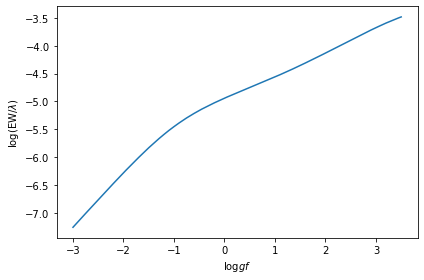

In [27]:
plt.plot(c.loggf, c.logrw)
plt.xlabel('$\log{gf}$'); plt.ylabel('$\log{(\mathrm{EW}/\lambda)}$')
plt.tight_layout()
plt.savefig(internal_path+'cog.png', dpi=250)

## weedout

In [33]:
w = pymoog.weedout.weedout(5000, 4.0, 0, 10830-15, 10830+15, kappa_ratio=0.2, line_list='vald_3000_11000',)
w.prepare_file()
w.run_moog()
w.compare(50000)

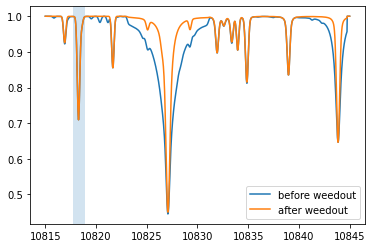

In [43]:
plt.plot(w.wav_all, w.flux_all, label='before weedout')
plt.plot(w.wav_keep, w.flux_keep, label='after weedout')
plt.legend()
# plt.savefig(internal_path+'weedout.png', dpi=250)

plt.axvspan(10817.7, 10818.9, alpha=0.2)

In [47]:
pymoog.line_data.find_single_dominant_line(10818.3, 5000, 4.0, 0, 28000, line_list='vald_3000_11000', weedout_switch=True)

,wavelength,id,EP,loggf,C6,D0,EW,r_blend_depth
0,10818.275,26.0,3.96,-1.948,-7.82,NaN,NaN,0.022774


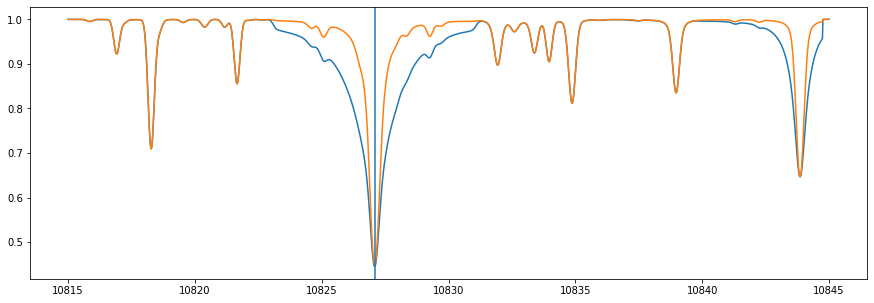

In [17]:
plt.figure(figsize=(15,5))
plt.plot(w.wav_all, w.flux_all)
plt.plot(w.wav_keep, w.flux_keep)
plt.xlim(plt.xlim())
plt.axvline(10827.0880)
# wav, flux = rulerwd.winered.read_spec('/media/disk/researches/data/Kovtyukh_spectra/2015/2015_10_25/HD219134_pipeline_ver3.5/HD219134_sum/AIR_norm/fsr1.05/tell_corrected/HD219134_sum_m52_fsr1.05_AIR_norm.fits')
# plt.plot(wav+1, flux)

In [57]:
b = pymoog.blends.blends(5000, 4.0, 0, 10817.7, 10818.9, 80, 26, line_list='vald_3000_11000')
b.prepare_file()
b.run_moog(output=True)
b.read_output()

 *******************************************************************************
                          MOOG LTE VERSION (NOV 2019)                           
MOOG PARAMETERS; here is the filename: batch.par                                
                       MOOG IS CONTROLLED BY DRIVER blends 
 *******************************************************************************
STANDARD OUTPUT; here is the filename: MOOG.out1                                
SUMMARY ABUNDANCE OUTPUT; here is the filename: MOOG.out2                       
THE MODEL ATMOSPHERE; here is the filename: model.mod                           
THE LINE LIST; here is the filename: line.list                                  
SPECIES USES MOLECULAR EQUILIBRIUM!  REDO WITH NEW ABUNDANCE ([y]/n)? 
5 32


## Real case test

Solar and Arcturus, and MgH for Mg abundance

In [63]:
# Read the solar WINERED spectra 
order = 45

standard_path = '/media/disk/researches/data/Kovtyukh_spectra/2015/2015_10_31/HD3421_pipeline_ver3.5/HD3421_sum/AIR_norm/fsr1.05/HD3421_sum_m{}_fsr1.05_AIR_norm.fits'.format(order)
wav_stan, flux_stan = rulerwd.winered.read_spec(standard_path)

shift_dict = {42:0, 43:7.5, 44:6, 45:9, 46:10, 47:10, 48:10, 49:0,
              50:0, 51:11, 52:12, 53:13, 54:12, 55:11, 56:12.5, 57:13, 58:10, 59:0, 60:0, 61:0}
sun_path = '/media/disk/researches/data/Kovtyukh_spectra/2014/2014_01_23/moon_fulap_pipeline_ver3.5/moon_sum/AIR_norm/fsr1.05/tell_corrected/'
wav, flux = rulerwd.winered.read_spec(sun_path + 'moon_sum_m{}_fsr1.05_AIR_norm.fits'.format(order))
wav = wav + shift_dict[order]/3e5*wav

used_order = [43,44,45,46,47,48,51,52,53,54,55,56,57]

In [3]:
def detect_single_feature(wav, flux, depth_cut=0.001):

    dflux = rulerwd.pandora.calculate_dz(flux)

    feature_sep = [0]
    for i in range(1, len(flux)-1):
        if dflux[i] > 0 and dflux[i+1] < 0:
            feature_sep.append(i)
    feature_sep.append(len(flux)-1)

    feature_min = []
    for i in range(len(feature_sep)-1):
        if 1 - np.min(flux[feature_sep[i]:feature_sep[i+1]]) > depth_cut: 
            feature_min.append(range(len(wav))[feature_sep[i]:feature_sep[i+1]][np.argmin(flux[feature_sep[i]:feature_sep[i+1]])])
        
    feature_min, feature_sep = np.array(feature_min), np.array(feature_sep)
    # Remove the separation with no detected features.
    clean_feature_sep = np.array([])
    for ele in feature_min.astype(int):
        index = np.argmin(np.abs(feature_sep-ele))
        if feature_sep[index] > ele:
            index = feature_sep[index-1:index+1]
        else:
            index = feature_sep[index:index+2]
        clean_feature_sep = np.concatenate([clean_feature_sep, index])

    clean_feature_sep = np.unique(clean_feature_sep)

    return feature_min.astype(int), clean_feature_sep.astype(int)

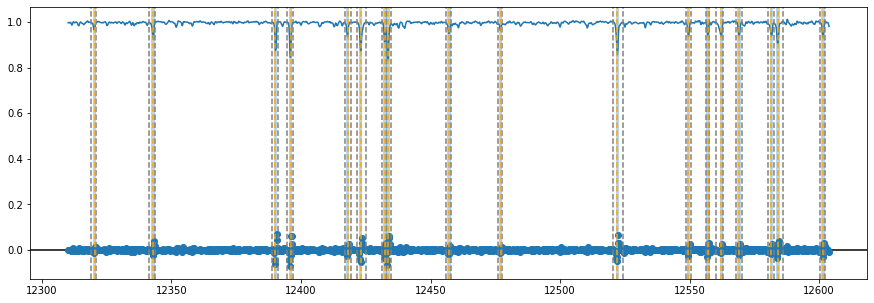

In [138]:
sub_wav = wav
sub_flux = flux

# Figure for development
feature_min, feature_sep = detect_single_feature(sub_wav, sub_flux, depth_cut=0.03)

plt.figure(figsize=(15,5))
plt.plot(sub_wav, sub_flux)
plt.scatter(sub_wav, rulerwd.pandora.calculate_dz(sub_flux))
plt.axhline(0, c='k', zorder=0)

for ele in feature_sep:
    plt.axvline(sub_wav[ele], ls='--', c='gray')

for ele in feature_min:
    plt.axvline(sub_wav[ele], ls='--', c='orange')
    plt.axvspan(sub_wav[ele]-0.7, sub_wav[ele]+0.7, alpha=0.3)

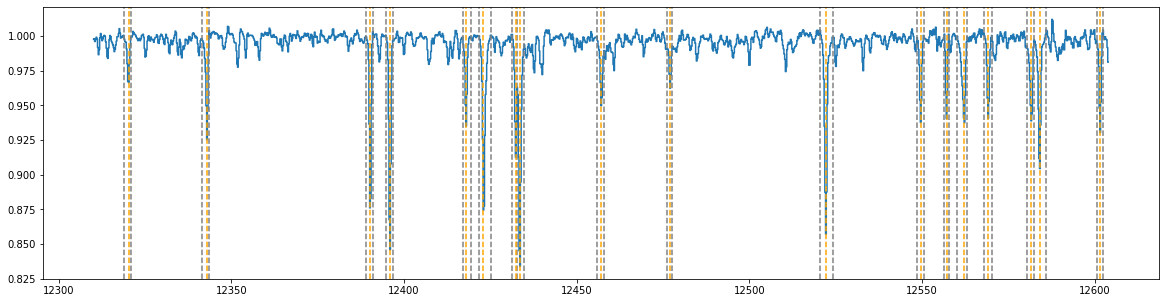

In [6]:
feature_min, feature_sep = detect_single_feature(wav, flux, depth_cut=0.03)

plt.figure(figsize=(20,5))
plt.step(wav, flux, where='mid')

for ele in feature_sep:
    plt.axvline(wav[ele], ls='--', c='gray')

for ele in feature_min:
    plt.axvline(wav[ele], ls='--', c='orange')
    # plt.axvspan(wav[ele]-measure_radius/2, wav[ele]+measure_radius/2, alpha=0.3)

# plt.xlim(9425, 9475)

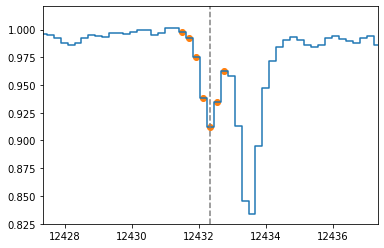

In [81]:
i = 6
feature_sep_sub = np.sort(feature_sep[np.argsort(np.abs(feature_sep-feature_min[6]))][0:2])
plt.step(wav, flux, where='mid')
plt.xlim(wav[feature_min][i]-5, wav[feature_min][i]+5)
plt.axvline(wav[feature_min][i], ls='--', c='gray')
indices = (np.abs(wav - wav[feature_min][i]) < 1) & (wav >= wav[feature_sep_sub[0]]) & (wav <= wav[feature_sep_sub[1]]) 
plt.scatter(wav[indices], flux[indices], c='C1')

In [4]:
from scipy.optimize import curve_fit

def Gauss_func(x, a, x0, sigma):
    '''
    Function for defining the Guassian function.
    '''
    res = 1 - a * np.exp(-(x - x0)**2 / (2*sigma**2))
    return res

def measure_EW(wav, flux, feature_min, feature_sep, half_width=1, plot=False):
    EW = []
    multi = False
    if len(feature_min) > 1 and plot:
        multi = True
        rows = int(np.ceil(len(feature_min)/4))
        plt.figure(figsize=(18,3*rows))
    j = 1
    for ele in feature_min:
        single_line = wav[ele]
        feature_sep_sub = np.sort(feature_sep[np.argsort(np.abs(feature_sep-ele))][0:2])
        
        indices_use = (np.abs(wav - single_line) < half_width) & (wav >= wav[feature_sep_sub[0]]) & (wav <= wav[feature_sep_sub[1]]) 
        wav_use = wav[indices_use]
        flux_use = flux[indices_use]
        gauss_res = curve_fit(Gauss_func, wav_use, flux_use, p0=[0.5, single_line, 1], bounds=[[0, single_line-0.05, 0], [1, single_line+0.05, 2]])
        
        EW_single = np.abs(gauss_res[0][0] * gauss_res[0][2] * np.sqrt(2*np.pi))
        EW.append(EW_single)
        if plot:
            if multi:
                plt.subplot(rows, 4, j)
                j += 1
            plt.scatter(wav_use, flux_use, s=10, c='C1')
            plot_x = np.arange(single_line-1, single_line+1, 0.01)
            plot_y = Gauss_func(plot_x, *gauss_res[0])
            plt.plot(plot_x, plot_y)

    if len(EW) == 1:
        EW = EW[0]
    else:
        EW = np.array(EW)
    if multi:
        plt.tight_layout()
    return EW

array([0.0262848 , 0.04800638, 0.07945114, 0.10295837, 0.04361028,
       0.10584872, 0.06155748, 0.13886677, 0.04326959, 0.02993528,
       0.1140116 , 0.04368383, 0.03413405, 0.0629623 , 0.04411795,
       0.05694536, 0.0771954 , 0.0448389 ])

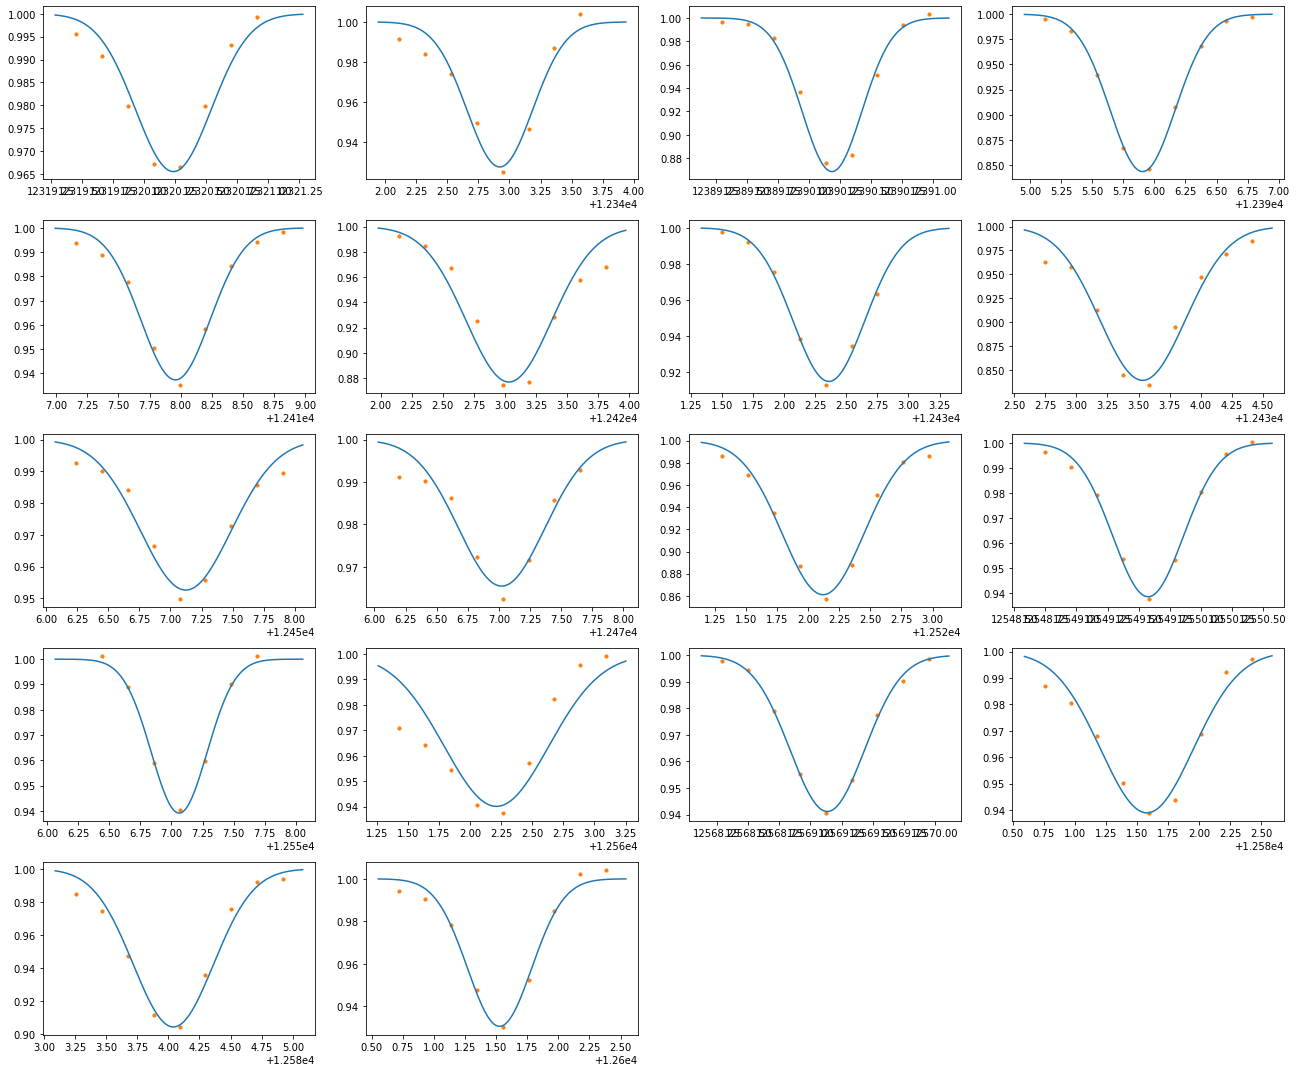

In [7]:
EW_measure = measure_EW(wav, flux, feature_min, feature_sep, plot=False)
EW_measure

In [8]:
from tqdm import tqdm

In [10]:
teff = 5777; logg = 4.43; fe_h = 0
resolution = 28000

i = 1
for line in tqdm(wav[feature_min]):
    res = pymoog.line_data.find_single_dominant_line(line, teff, logg, fe_h, 28000, line_list='vald_11000_24000', weedout_switch=True, search_half_width=0.7)
    if i == 1:
        res_all = res
    else:
        res_all = pd.concat([res_all, res])
    i += 1
res_all = res_all.reset_index(drop=True)

100%|██████████| 18/18 [01:01<00:00,  3.41s/it]


In [12]:
res_all['EW'] = EW_measure*1000
res_all

,wavelength,id,EP,loggf,C6,D0,EW,r_blend_depth
0,NaN,NaN,NaN,NaN,NaN,NaN,26.284799,NaN
1,12342.916,26.0,4.638,-1.463,-7.540,NaN,48.006377,0.006584
2,12390.154,14.0,5.082,-1.767,-7.520,NaN,79.451139,0.008853
3,12395.832,14.0,4.954,-1.644,2.830,NaN,102.958371,0.003593
4,12417.937,12.0,5.932,-1.664,0.000,NaN,43.610282,0.002760
5,NaN,NaN,NaN,NaN,NaN,NaN,105.848724,NaN
6,12432.273,19.0,1.610,-0.439,3.100,NaN,61.557481,0.022258
7,12433.452,12.0,5.933,-0.967,0.000,NaN,138.866771,0.083325
8,NaN,NaN,NaN,NaN,NaN,NaN,43.269591,NaN
9,12477.598,26.0,6.222,-1.066,-7.180,NaN,29.935279,0.000000


In [13]:
res_all_use = res_all[~np.isnan(res_all['wavelength'])].reset_index(drop=True).drop(columns='r_blend_depth')
res_all_use

,wavelength,id,EP,loggf,C6,D0,EW
0,12342.916,26.0,4.638,-1.463,-7.540,NaN,48.006377
1,12390.154,14.0,5.082,-1.767,-7.520,NaN,79.451139
2,12395.832,14.0,4.954,-1.644,2.830,NaN,102.958371
3,12417.937,12.0,5.932,-1.664,0.000,NaN,43.610282
4,12432.273,19.0,1.610,-0.439,3.100,NaN,61.557481
5,12433.452,12.0,5.933,-0.967,0.000,NaN,138.866771
6,12477.598,26.0,6.222,-1.066,-7.180,NaN,29.935279
7,12549.479,6.0,8.847,-0.565,2.937,NaN,43.683831
8,12556.996,26.0,2.279,-3.626,-7.820,NaN,34.134053
9,12569.032,6.0,8.848,-0.598,2.937,NaN,44.117951


In [14]:
a = pymoog.abfind.abfind(teff, logg, fe_h, line_list='line.list')
a.prepare_file()
res_all_use = res_all_use.sort_values(['id', 'wavelength']).reset_index(drop=True)
pymoog.line_data.save_linelist(res_all_use, MOOG_run_path + 'line.list')
a.run_moog(output=True)


 *******************************************************************************
                          MOOG LTE VERSION (NOV 2019)                           
MOOG PARAMETERS; here is the filename: batch.par                                
                       MOOG IS CONTROLLED BY DRIVER abfind 
 *******************************************************************************
STANDARD OUTPUT; here is the filename: MOOG.out1                                
SUMMARY ABUNDANCE OUTPUT; here is the filename: MOOG.out2                       
THE MODEL ATMOSPHERE; here is the filename: model.mod                           
THE LINE LIST; here is the filename: line.list                                  
                                                                                
 <<<<<<<<<<<<<<<<<<<<<<          MOOG HAS ENDED!          >>>>>>>>>>>>>>>>>>>>>>


In [22]:
a_res = a.read_output()

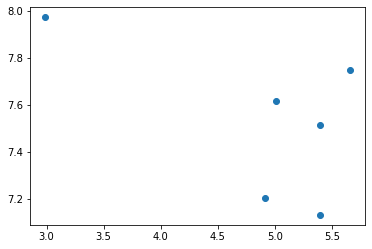

In [26]:
plt.scatter(a_res[26]['EP'], a_res[26]['abund'])

In [75]:
line1

10843.349985200028

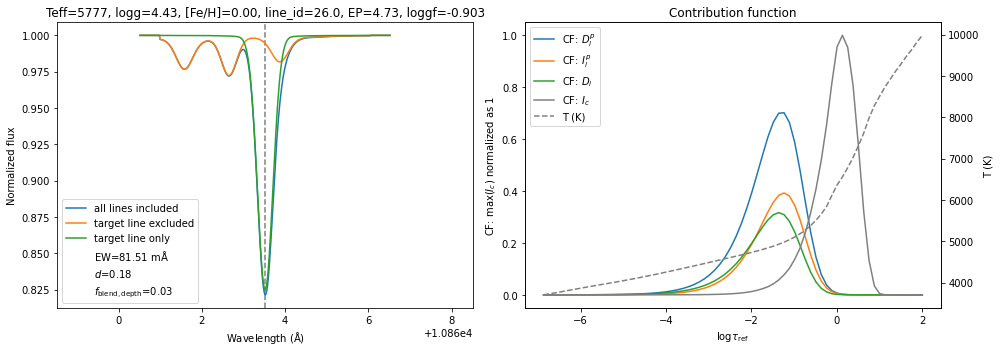

In [4]:
pymoog.contri_func.plot_contri_func(teff, logg, fe_h, resolution, 'vald_3000_11000', target_line_df=res)